<a href="https://colab.research.google.com/github/blueberricheesecake/Diabetes-Prediction/blob/main/project_diabetes_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing Data and dataframe creation

In [ ]:
#Importing the libraries here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
from sklearn.model_selection import KFold,train_test_split,GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from scipy import stats
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, precision_score, recall_score, f1_score

In [ ]:
#Loading the data
url = 'https://raw.githubusercontent.com/Rajvir0712/diabetes/main/diabetes.csv'
database = pd.read_csv(url)

In [ ]:
database.head()
database["Outcome"].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

In [ ]:
database.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


#Preprocessing Step - For preprocessing we will do 2 things, outlier rejections and filling missing values and Standardization if necessary and doing feature selection based on correlation.

In [ ]:
database.isnull().values.any()

False

Here we can see that our database has no missing values

In [ ]:
threshold = 3

# Calculate Z-scores for all columns except 'Outcome'
features = database.drop('Outcome', axis=1)
z_scores = stats.zscore(features)

# Calculate absolute Z-scores
abs_z_scores = np.abs(z_scores)

# Create a boolean mask where True indicates the rows that do not contain outliers
filtered_entries = (abs_z_scores < threshold).all(axis=1)

# Apply the mask to the DataFrame to get a cleaned dataset without outliers
cleaned_data = database[filtered_entries]

database = cleaned_data
cleaned_data.head()
cleaned_data['Outcome'].value_counts()

0    461
1    227
Name: Outcome, dtype: int64

In [ ]:
def reject_outliers(df, m=1.5):
    outlier_indices = []
    for col in df.select_dtypes(include=['float64', 'int64']).columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - m * IQR
        upper_bound = Q3 + m * IQR
        outlier_col = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index
        outlier_indices.extend(outlier_col)
    outlier_indices = list(set(outlier_indices))  # Remove duplicates
    df_no_outliers = df.drop(index=outlier_indices)
    return df_no_outliers

# Applying the function to the DataFrame without the 'Outcome' column
features = database.drop('Outcome', axis=1)
cleaned_data_no_outliers = reject_outliers(features)

# Add the 'Outcome' column back to the cleaned data
cleaned_data_no_outliers['Outcome'] = database.loc[cleaned_data_no_outliers.index, 'Outcome']
database = cleaned_data_no_outliers

database['Outcome'].value_counts()


0    429
1    190
Name: Outcome, dtype: int64

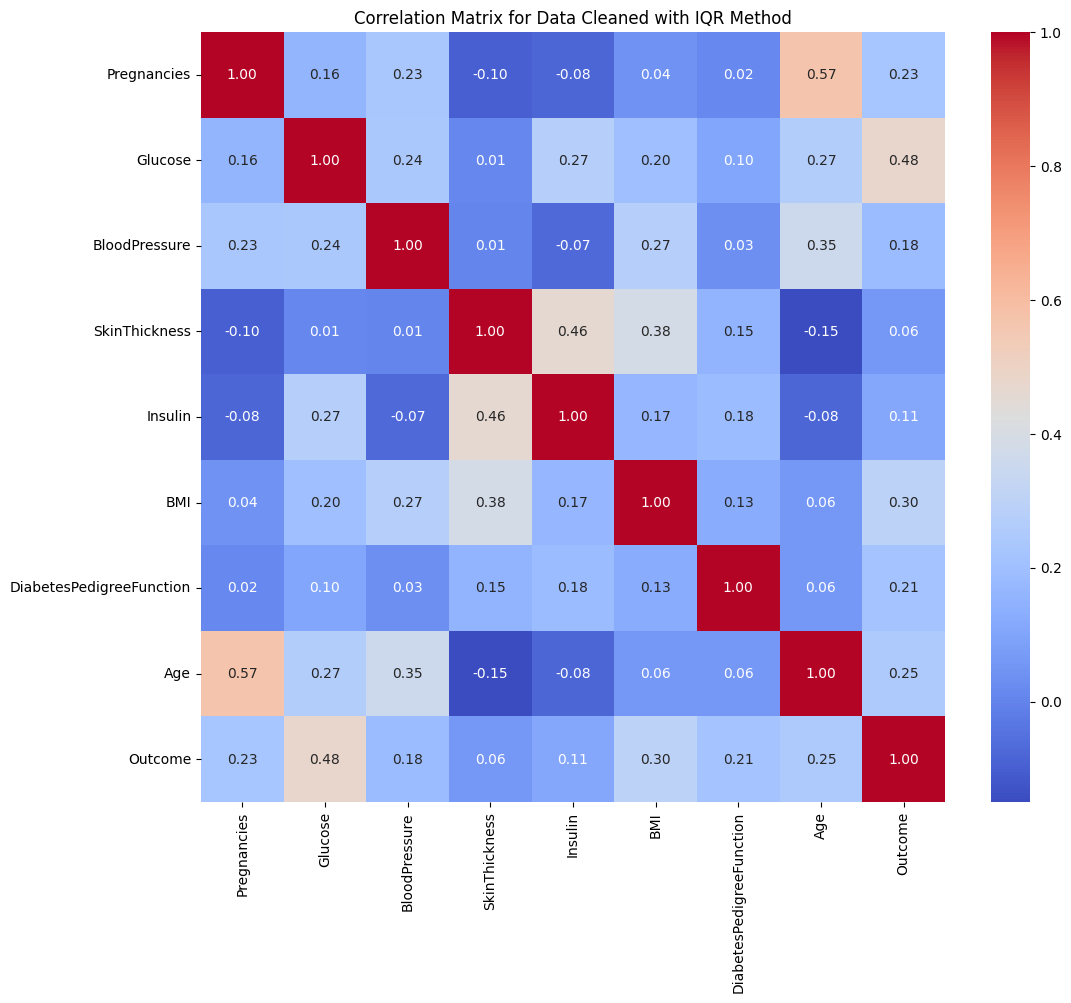

In [ ]:
# Calculating the correlation matrix for the dataset after outlier rejection using the IQR method
corr_matrix_iqr_cleaned = cleaned_data.corr()

# Visualizing the correlation matrix using a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix_iqr_cleaned, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix for Data Cleaned with IQR Method')
plt.show()

# Good to predict positive false, not positive true. Therefore, this model is good at finding who is unlikely to get diabetes.

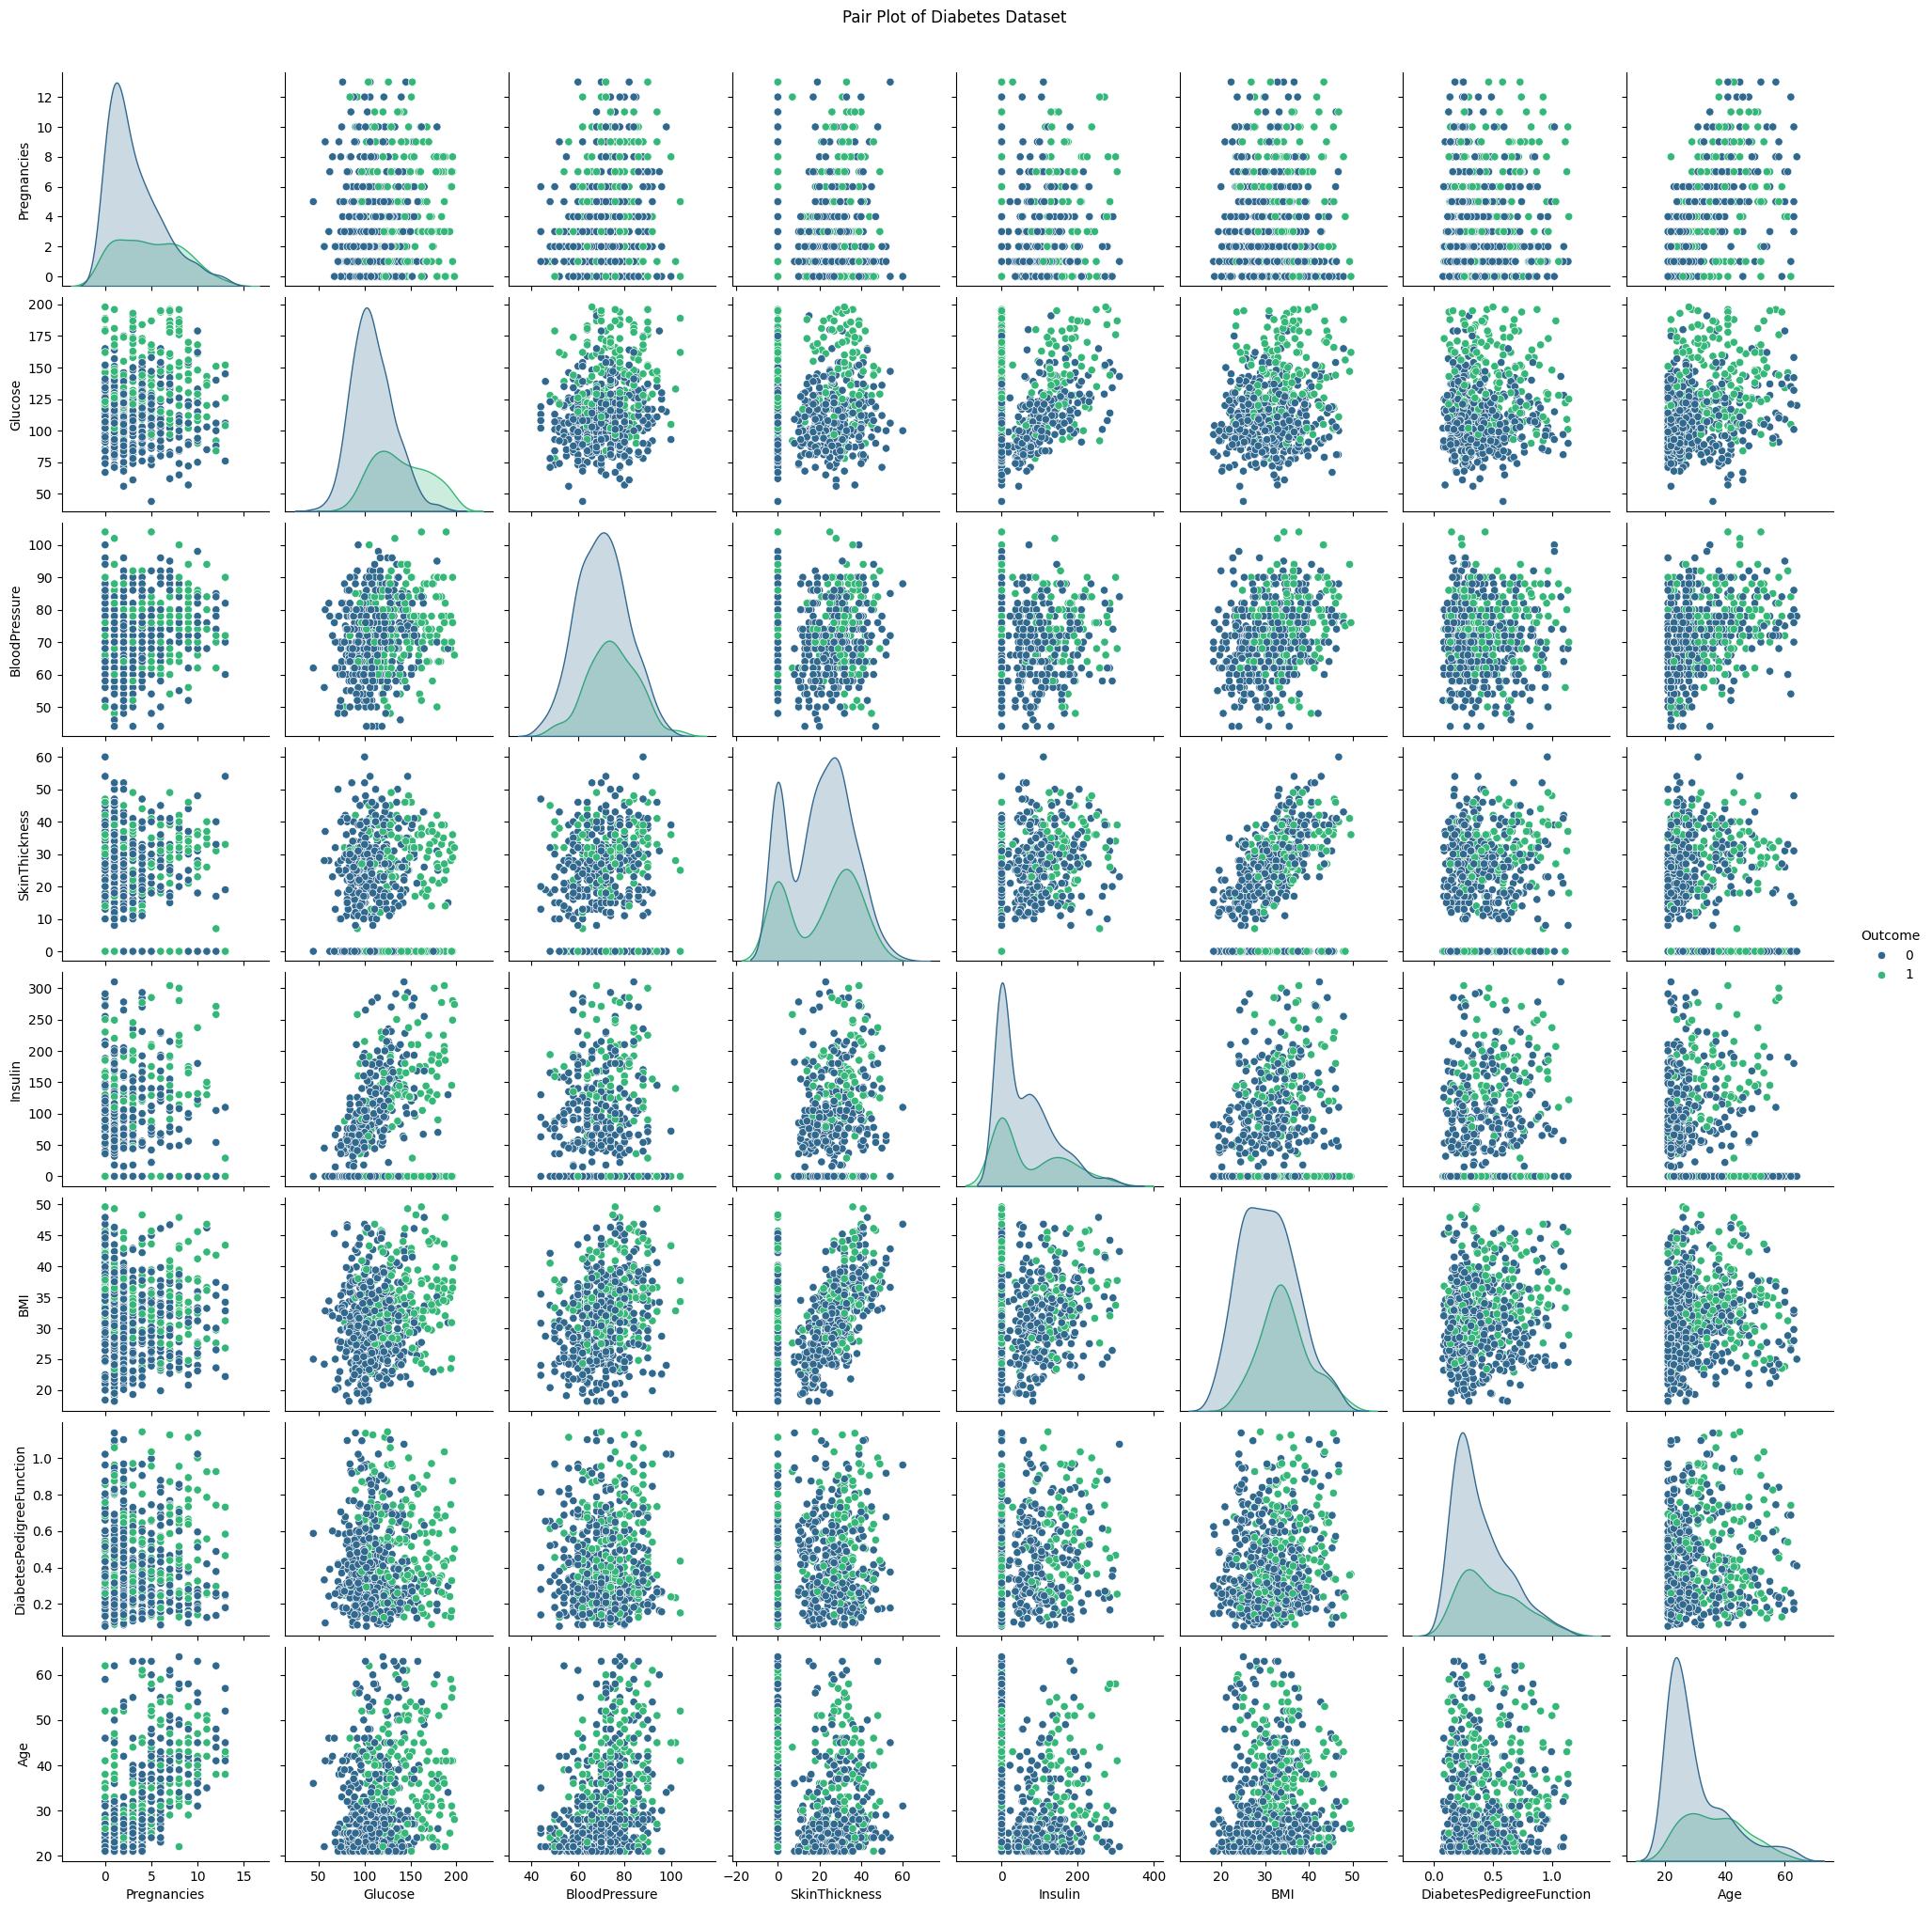

In [ ]:
# we need to select the variables, according to RV's work. Now, it is too much.
sns.pairplot(data=database, hue='Outcome', palette='viridis')
plt.suptitle('Pair Plot of Diabetes Dataset', y=1.02)
plt.show()

We did outlier rejection using Z-score. You can create features and their graphs to show outlier while doing data vsualization. Z-score with value less than -3 or more than +3 is called outlier here.

In [ ]:
X = database.drop('Outcome', axis=1)  # Features
y = database['Outcome']
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

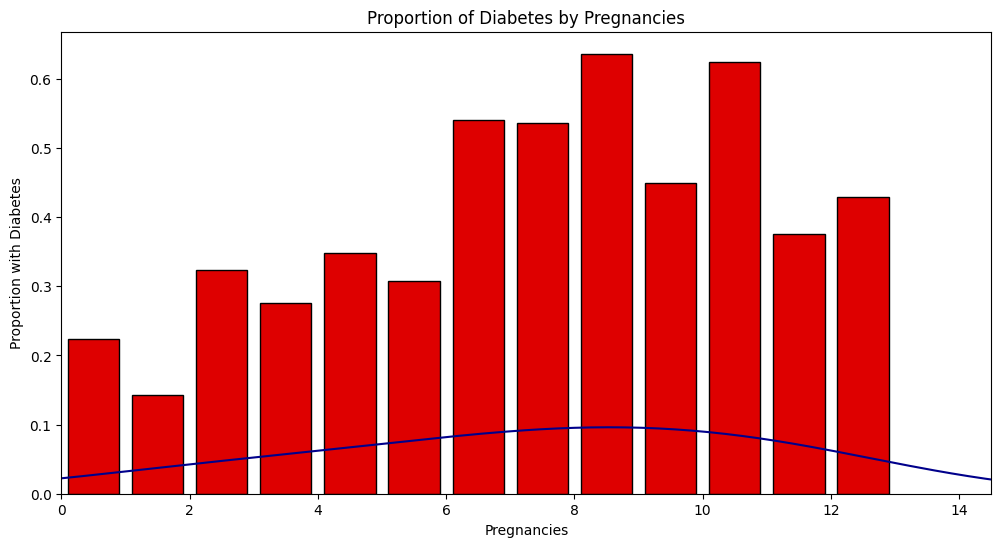

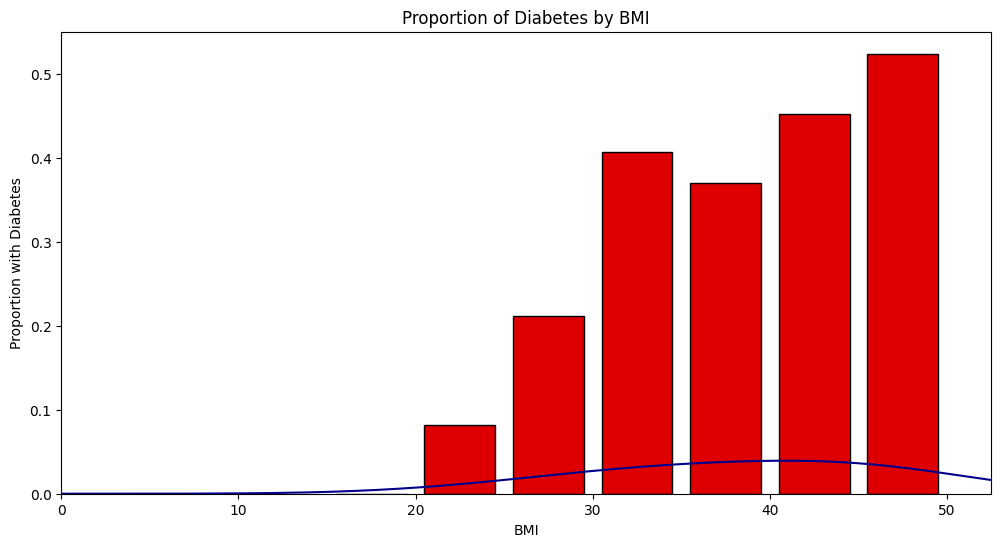

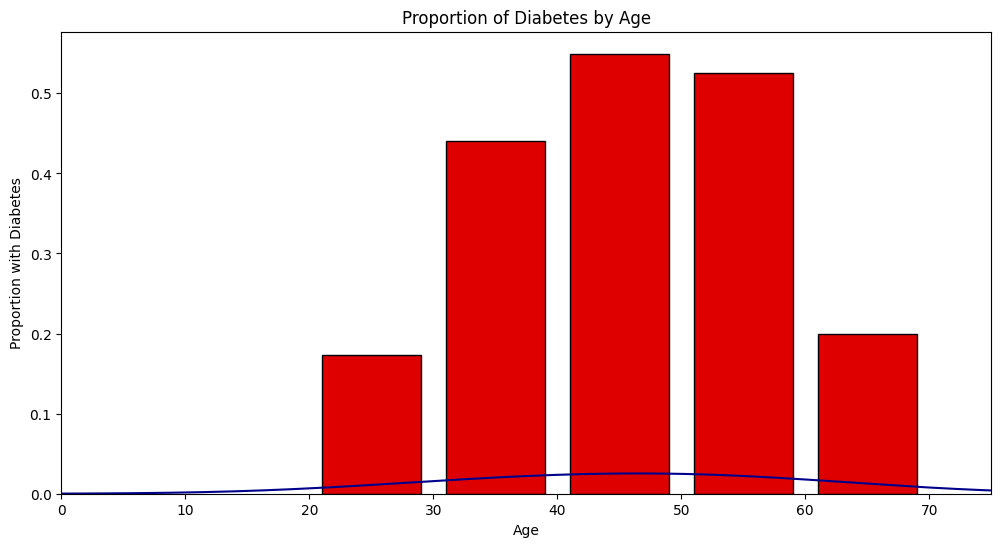

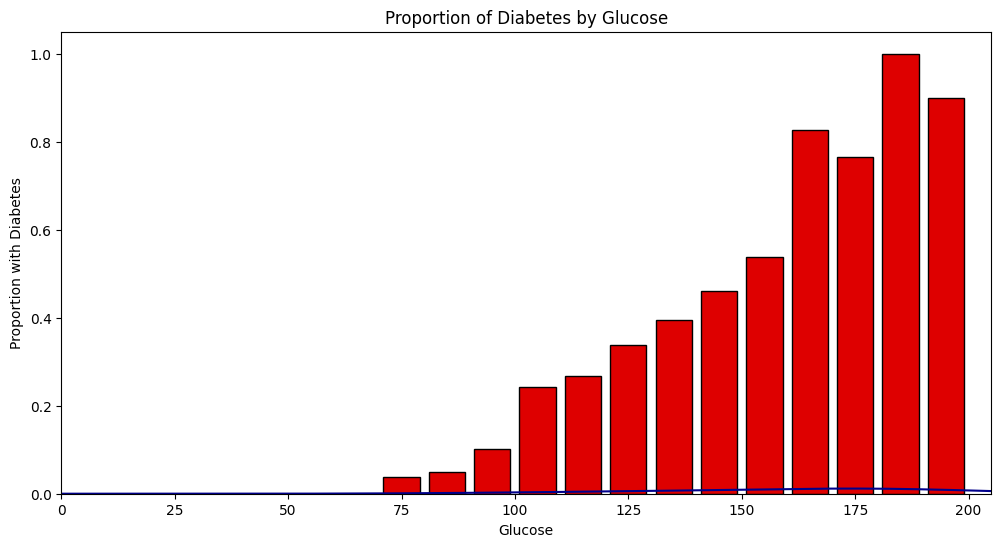

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

viridis_color = (0.87, 0, 0)

def plot_proportion_with_trendline(data, column, bins, title, color):
    data = data.copy()

    data['bin'] = pd.cut(data[column], bins=bins, include_lowest=True)
    bin_centers = [0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)]

    proportion = data.groupby('bin')['Outcome'].mean()

    plt.figure(figsize=(12, 6))
    bars = plt.bar(bin_centers, proportion, color=color, edgecolor='black', width=np.diff(bins)*0.8)
    plt.title(f'Proportion of Diabetes by {title}')
    plt.xlabel(title)
    plt.ylabel('Proportion with Diabetes')

    plt.xlim(0, max(bin_centers) + np.diff(bins)[0])

    sns.kdeplot(x=bin_centers, weights=proportion, color='darkblue', ax=plt.gca())

    plt.show()

pregnancy_bins = range(int(database['Pregnancies'].max() + 2))
age_bins = range(0, int(database['Age'].max()) + 10, 10)
glucose_bins = range(0, int(database['Glucose'].max()) + 10, 10)
bmi_bins = range(0, int(database['BMI'].max()) + 5, 5)

plot_proportion_with_trendline(database, 'Pregnancies', pregnancy_bins, 'Pregnancies', viridis_color)
plot_proportion_with_trendline(database, 'BMI', bmi_bins, 'BMI', viridis_color)
plot_proportion_with_trendline(database, 'Age', age_bins, 'Age', viridis_color)
plot_proportion_with_trendline(database, 'Glucose', glucose_bins, 'Glucose', viridis_color)

#Feature based model selection based on correlation

In [ ]:
# Calculate correlation matrix with respect to the target variable 'Outcome'
correlation_matrix = database.corr()['Outcome'].sort_values()

# Select features with correlation above the threshold
threshold = 0.2
features_above_threshold = correlation_matrix[abs(correlation_matrix) >= threshold].index.tolist()

# Remove the target variable 'Outcome' from the features list if it's included
features_above_threshold.remove('Outcome')

# Create a new dataframe with the selected features plus the target variable
selected_data = database[features_above_threshold + ['Outcome']]

# Now `selected_data` contains only the features with a correlation above 0.2 with the target variable
print("Selected features based on correlation threshold:", features_above_threshold)
print(selected_data.head())

database = selected_data


Selected features based on correlation threshold: ['Pregnancies', 'BMI', 'Age', 'Glucose']
   Pregnancies   BMI  Age  Glucose  Outcome
0            6  33.6   50      148        1
1            1  26.6   31       85        0
2            8  23.3   32      183        1
3            1  28.1   21       89        0
5            5  25.6   30      116        0


The paper said standardization reduces accuracy, still if you guys want I can do it. I left the above cell empty for that.

#K FOLD AND SPLITTING DATA

In [ ]:
# Assuming 'data' is your DataFrame and 'Outcome' is the target variable.
X = database.drop('Outcome', axis=1)  # Features
y = database['Outcome']  # Target variable

# First, split the data into a training set and a hold-out test set
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Define the KFold cross-validator
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Placeholder for the model's validation scores
validation_scores = []

# Initialize the XGBoost classifier
model = XGBClassifier(random_state=42)

# Iterate over each fold
for train_index, val_index in kf.split(X_train_full):
    # Split the data into k-fold train and validation sets
    X_train, X_val = X_train_full.iloc[train_index], X_train_full.iloc[val_index]
    y_train, y_val = y_train_full.iloc[train_index], y_train_full.iloc[val_index]

    # Fit the model
    model.fit(X_train, y_train)

    # Predict on the validation set
    y_val_pred = model.predict(X_val)

    # Evaluate the model
    val_score = accuracy_score(y_val, y_val_pred)
    validation_scores.append(val_score)

    # Optionally, you can print out the validation score for each fold
    print(f'Validation score for fold: {val_score}')

# After cross-validation, you might want to fit the model on the entire training set
# and evaluate it on the hold-out test set
model.fit(X_train_full, y_train_full)
y_test_pred = model.predict(X_test)
test_score = accuracy_score(y_test, y_test_pred)

print(f'Test score: {test_score}')

# The validation_scores list contains the validation accuracy for each fold
print(f'Average validation score: {sum(validation_scores) / len(validation_scores)}')

#More robust model is Threshold/z_score model. Test Score and Average score are almost equal.

Validation score for fold: 0.7575757575757576
Validation score for fold: 0.8181818181818182
Validation score for fold: 0.6666666666666666
Validation score for fold: 0.7171717171717171
Validation score for fold: 0.7878787878787878
Test score: 0.6935483870967742
Average validation score: 0.7494949494949494


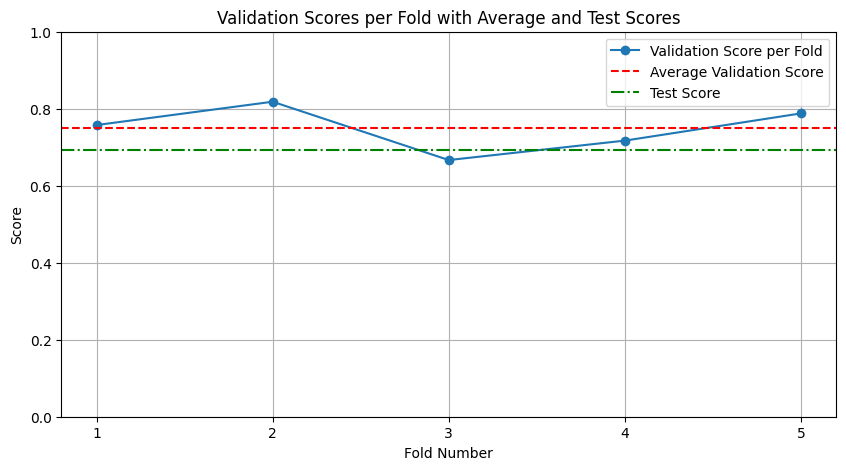

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'validation_scores' is your list of scores from each fold
folds = range(1, len(validation_scores) + 1)
average_validation_score = sum(validation_scores) / len(validation_scores)
test_score = 0.6935483870967742  # Replace with your actual test score

# Line Plot with Y-axis from 0 to 1 and additional horizontal lines for average and test scores
plt.figure(figsize=(10, 5))
plt.plot(folds, validation_scores, marker='o', label='Validation Score per Fold')
plt.axhline(y=average_validation_score, color='r', linestyle='--', label='Average Validation Score')
plt.axhline(y=test_score, color='g', linestyle='-.', label='Test Score')

plt.title('Validation Scores per Fold with Average and Test Scores')
plt.xlabel('Fold Number')
plt.ylabel('Score')
plt.ylim(0, 1)  # Setting the Y-axis from 0 to 1
plt.xticks(folds)
plt.grid(True)
plt.legend()
plt.show()


Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.86      0.79        81
           1       0.59      0.37      0.46        43

    accuracy                           0.69       124
   macro avg       0.66      0.62      0.62       124
weighted avg       0.68      0.69      0.67       124



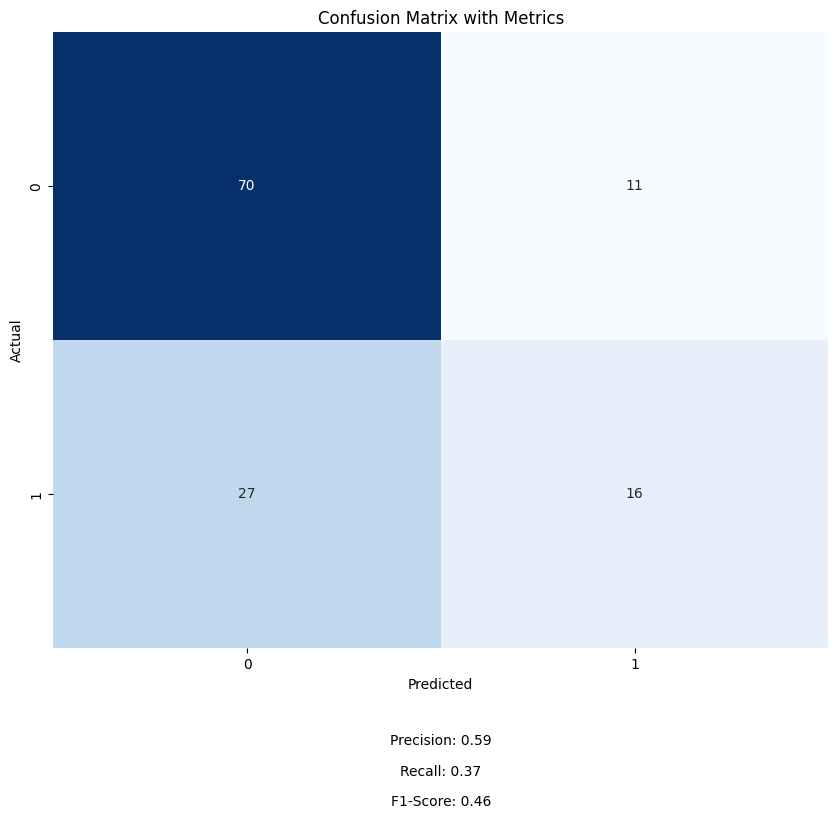

In [ ]:
# Confusion matrix and additional metrics
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_test_pred))

# Plotting the confusion matrix with additional details
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.text(0.5, -0.15, f'Precision: {precision_score(y_test, y_test_pred):.2f}', ha='center', va='center', transform=plt.gca().transAxes)
plt.text(0.5, -0.2, f'Recall: {recall_score(y_test, y_test_pred):.2f}', ha='center', va='center', transform=plt.gca().transAxes)
plt.text(0.5, -0.25, f'F1-Score: {f1_score(y_test, y_test_pred):.2f}', ha='center', va='center', transform=plt.gca().transAxes)
plt.title('Confusion Matrix with Metrics')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#Training, Grid search (Hyper-parameter tunning), fitting and testing

In [ ]:
#For Standardization
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_standardized, y, test_size=0.2, random_state=42)


In [ ]:
model = XGBClassifier(random_state=42)
param_grid = {
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1,0.01,0.05]
}
grid_search = GridSearchCV(model, param_grid, scoring='roc_auc', n_jobs=-1, cv=3, verbose=3)

# Fit the grid search to the data
grid_search.fit(X_train_1, y_train_1)

# Print the best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best AUC found: ", grid_search.best_score_)

# Predict on the test data with the best parameters
best_model = grid_search.best_estimator_
y_pred_prob = best_model.predict_proba(X_test_1)[:, 1]

# Calculate and print the AUC score for the best model
auc_score = roc_auc_score(y_test_1, y_pred_prob)
print(f"Test AUC Score with best parameters: {auc_score}")

Fitting 3 folds for each of 1215 candidates, totalling 3645 fits
Best parameters found:  {'colsample_bytree': 0.6, 'gamma': 5, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 5, 'subsample': 1.0}
Best AUC found:  0.8498123387285949
Test AUC Score with best parameters: 0.8011771461383865


# Sub-group analysis

<ipython-input-18-45c750f87c5e>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  database['BMI_Category'] = pd.cut(database['BMI'], bins=bins, labels=labels, right=False)


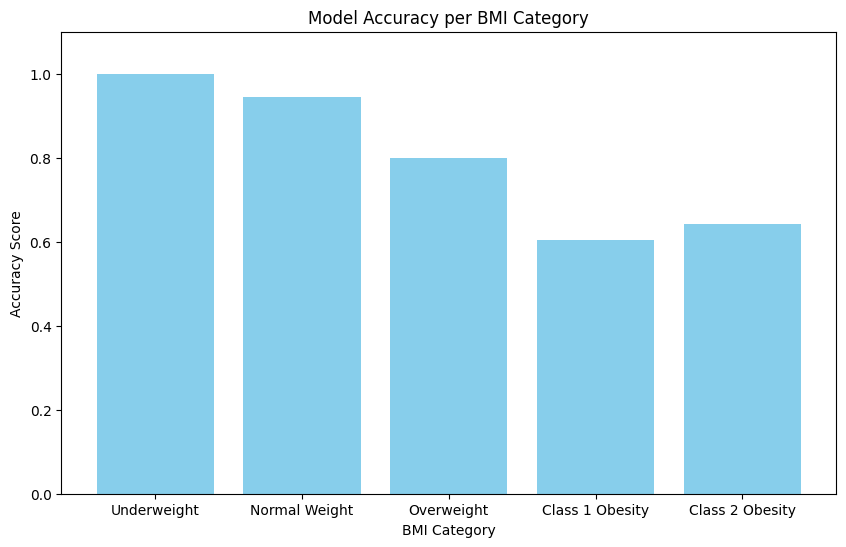

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Create BMI categories based on specified bins and labels
bins = [0, 18.5, 24.9, 29.9, 34.9, np.inf]
labels = ['Underweight', 'Normal Weight', 'Overweight', 'Class 1 Obesity', 'Class 2 Obesity']

# Replace 'database’ with your actual DataFrame name
database['BMI_Category'] = pd.cut(database['BMI'], bins=bins, labels=labels, right=False)

# Subgroup Analysis for each BMI category
accuracy_scores = []

for bmi_category in labels:
    # Filter data for the current BMI category
    bmi_subset = database[database['BMI_Category'] == bmi_category]

    # Features and target variable for the current subset
    X_bmi = bmi_subset.drop(['Outcome', 'BMI_Category'], axis=1)
    y_bmi = bmi_subset['Outcome']

    # Split the data into training and test sets
    X_train_bmi, X_test_bmi, y_train_bmi, y_test_bmi = train_test_split(X_bmi, y_bmi, test_size=0.2, random_state=42)

    # Initialize the XGBoost classifier
    model_bmi = XGBClassifier(random_state=42)

    # Fit the model on the subset
    model_bmi.fit(X_train_bmi, y_train_bmi)

    # Evaluate the model on the test set for the current BMI category
    y_test_pred_bmi = model_bmi.predict(X_test_bmi)
    test_score_bmi = accuracy_score(y_test_bmi, y_test_pred_bmi)

    # Append the accuracy score to the list
    accuracy_scores.append(test_score_bmi)

# Create a bar chart for accuracy scores with some space at the top
plt.figure(figsize=(10, 6))
plt.bar(labels, accuracy_scores, color='skyblue')
plt.title('Model Accuracy per BMI Category')
plt.xlabel('BMI Category')
plt.ylabel('Accuracy Score')
plt.ylim(0, 1.1)  # Set y-axis limit with some space at the top
plt.show()


<ipython-input-21-23c6c1de3a4a>:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Age_Category', y='Test_Accuracy', data=accuracy_df, palette='viridis')


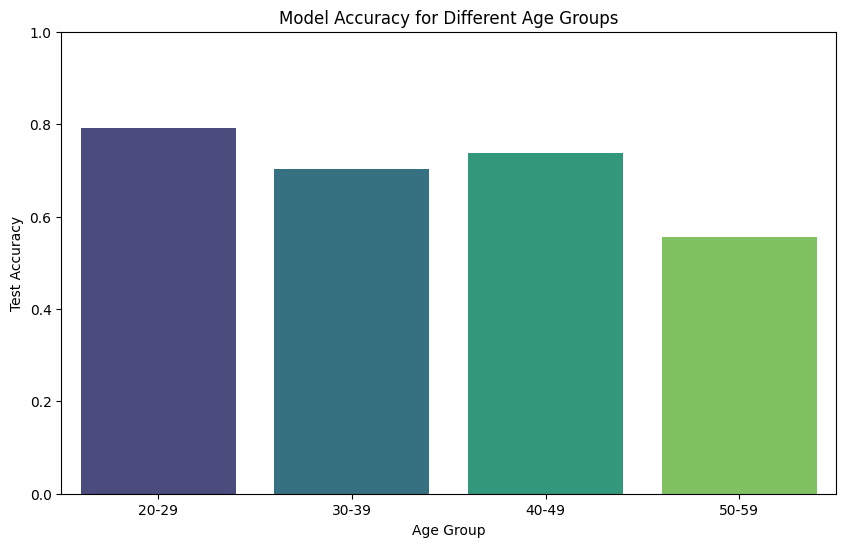

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

# Ensure you are working with a copy if 'database' is a slice
database = database.copy()

# Assuming 'Age' is a column in your dataset
# Create age categories based on specified bins and labels
bins = [20, 30, 40, 50, 60]
labels = ['20-29', '30-39', '40-49', '50-59']  # Adjust the number of labels to match bins
database['Age_Category'] = pd.cut(database['Age'], bins=bins, labels=labels, right=False, include_lowest=True)

# Dictionary to store accuracy scores for each age category
accuracy_scores = {'Age_Category': [], 'Test_Accuracy': []}

# Iterate over each age category
for age_category in labels:

    # Filter data for the current age category
    age_subset = database[database['Age_Category'] == age_category].copy()

    # Features and target variable for the current subset
    X_age = age_subset.drop(['Outcome', 'Age_Category'], axis=1)
    y_age = age_subset['Outcome']

    # Split the data into a training set and a hold-out test set
    X_train_age, X_test_age, y_train_age, y_test_age = train_test_split(
        X_age, y_age, test_size=0.2, random_state=42
    )

    # Initialize the XGBoost classifier with enable_categorical set to True
    model_age = XGBClassifier(random_state=42, enable_categorical=True)

    # Fit the model on the entire training set
    model_age.fit(X_train_age, y_train_age)

    # Evaluate the model on the hold-out test set for the current age category
    y_test_pred_age = model_age.predict(X_test_age)
    test_score_age = accuracy_score(y_test_age, y_test_pred_age)

    # Store accuracy scores in the dictionary
    accuracy_scores['Age_Category'].append(age_category)
    accuracy_scores['Test_Accuracy'].append(test_score_age)

# Convert the accuracy scores dictionary to a DataFrame
accuracy_df = pd.DataFrame(accuracy_scores)

# Plot the accuracy for each age group
plt.figure(figsize=(10, 6))
sns.barplot(x='Age_Category', y='Test_Accuracy', data=accuracy_df, palette='viridis')
plt.title('Model Accuracy for Different Age Groups')
plt.xlabel('Age Group')
plt.ylabel('Test Accuracy')
plt.ylim(0, 1)  # Set the y-axis limit to ensure a proper scale
plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1615: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=x, y=y, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1615: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=x, y=y, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1615: UserWarning: Ignoring `palette` because no `hue` variable has been as

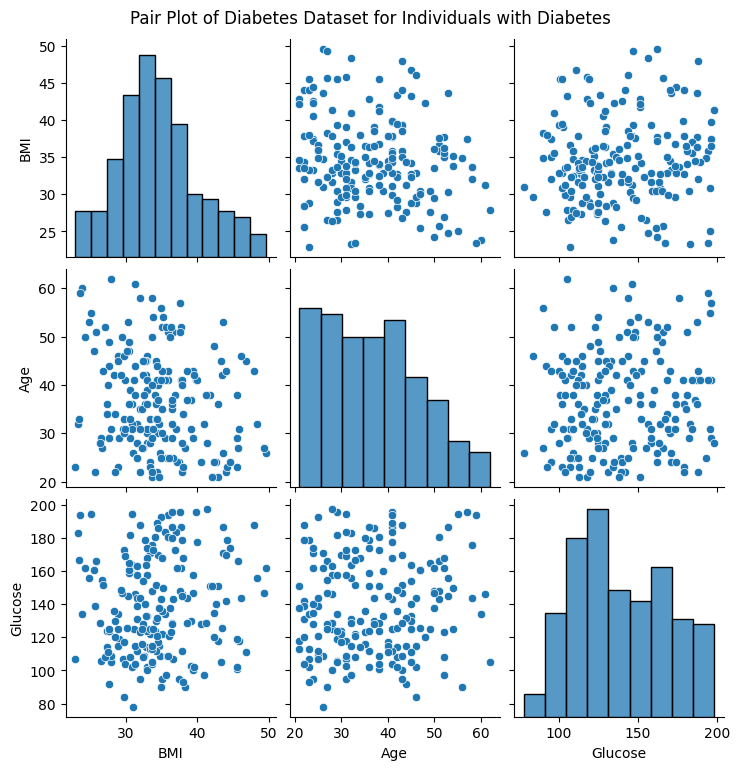

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter the database for individuals with diabetes ('Outcome' == 1)
diabetes_data = database[database['Outcome'] == 1]

# Select only the 'BMI', 'Age', and 'Glucose' columns for individuals with diabetes
selected_features = diabetes_data[['BMI', 'Age', 'Glucose']]

# Create the pair plot
sns.pairplot(selected_features, palette='viridis')
plt.suptitle('Pair Plot of Diabetes Dataset for Individuals with Diabetes', y=1.02)
plt.show()
